(optgrowth)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# {index}`Optimal Growth II: Accelerating the Code with Numba <single: Optimal Growth II: Accelerating the Code with Numba>`

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon
!pip install interpolation

## Overview

{doc}`Previously <optgrowth>`, we studied a stochastic optimal
growth model with one representative agent.

We solved the model using dynamic programming.

In writing our code, we focused on clarity and flexibility.

These are important, but there's often a trade-off between flexibility and
speed.

The reason is that, when code is less flexible, we can exploit structure more
easily.

(This is true about algorithms and mathematical problems more generally:
more specific problems have more structure, which, with some thought, can be
exploited for better results.)

So, in this lecture, we are going to accept less flexibility while gaining
speed, using just-in-time (JIT) compilation to
accelerate our code.

Let's start with some imports:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from interpolation import interp
from numba import jit, njit, prange, float64, int32
from numba.experimental import jitclass
from quantecon.optimize.scalar_maximization import brent_max

We are using an interpolation function from
[interpolation.py](https://github.com/EconForge/interpolation.py) because it
helps us JIT-compile our code.

The function `brent_max` is also designed for embedding in JIT-compiled code.

These are alternatives to similar functions in SciPy (which, unfortunately, are not JIT-aware).

## The Model

```{index} single: Optimal Growth; Model
```

The model is the same as discussed in our {doc}`previous lecture <optgrowth>`
on optimal growth.

We will start with log utility:

$$
u(c) = \ln(c)
$$

We continue to assume that

* $f(k) = k^{\alpha}$
* $\phi$ is the distribution of $\xi := \exp(\mu + s \zeta)$ when $\zeta$ is standard normal

We will once again use value function iteration to solve the model.

In particular, the algorithm is unchanged, and the only difference is in the implementation itself.

As before, we will be able to compare with the true solutions

In [3]:

def v_star(y, α, β, μ):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

def σ_star(y, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * y



## Computation

```{index} single: Dynamic Programming; Computation
```

We will again store the primitives of the optimal growth model in a class.

But now we are going to use [Numba's](https://python-programming.quantecon.org/numba.html) `@jitclass` decorator to target our class for JIT compilation.

Because we are going to use Numba to compile our class, we need to specify the data types.

You will see this as a list called `opt_growth_data` above our class.

Unlike in the {doc}`previous lecture <optgrowth>`, we
hardwire the production and utility specifications into the
class.

This is where we sacrifice flexibility in order to gain more speed.

In [4]:

opt_growth_data = [
    ('α', float64),          # Production parameter
    ('β', float64),          # Discount factor
    ('μ', float64),          # Shock location parameter
    ('s', float64),          # Shock scale parameter
    ('grid', float64[:]),    # Grid (array)
    ('shocks', float64[:])   # Shock draws (array)
]

@jitclass(opt_growth_data)
class OptimalGrowthModel:

    def __init__(self,
                α=0.4, 
                β=0.96, 
                μ=0,
                s=0.1,
                grid_max=4,
                grid_size=120,
                shock_size=250,
                seed=1234):

        self.α, self.β, self.μ, self.s = α, β, μ, s

        # Set up grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)

        # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))
       

    def f(self, k):
        "The production function"
        return k**self.α
       

    def u(self, c):
        "The utility function"
        return np.log(c)

    def f_prime(self, k):
        "Derivative of f"
        return self.α * (k**(self.α - 1))


    def u_prime(self, c):
        "Derivative of u"
        return 1/c

    def u_prime_inv(self, c):
        "Inverse of u'"
        return 1/c




The class includes some methods such as `u_prime` that we do not need now
but will use in later lectures.

### The Bellman Operator

We will use JIT compilation to accelerate the Bellman operator.

First, here's a function that returns the value of a particular consumption choice `c`, given state `y`, as per the Bellman equation {eq}`fpb30`.

In [5]:
@njit
def state_action_value(c, y, v_array, og):
    """
    Right hand side of the Bellman equation.

     * c is consumption
     * y is income
     * og is an instance of OptimalGrowthModel
     * v_array represents a guess of the value function on the grid

    """

    u, f, β, shocks = og.u, og.f, og.β, og.shocks

    v = lambda x: interp(og.grid, v_array, x)

    return u(c) + β * np.mean(v(f(y - c) * shocks))

Now we can implement the Bellman operator, which maximizes the right hand side
of the Bellman equation:

In [6]:
@jit(nopython=True)
def T(v, og):
    """
    The Bellman operator.

     * og is an instance of OptimalGrowthModel
     * v is an array representing a guess of the value function

    """

    v_new = np.empty_like(v)
    v_greedy = np.empty_like(v)

    for i in range(len(og.grid)):
        y = og.grid[i]

        # Maximize RHS of Bellman equation at state y
        result = brent_max(state_action_value, 1e-10, y, args=(y, v, og))
        v_greedy[i], v_new[i] = result[0], result[1]

    return v_greedy, v_new

We use the `solve_model` function to perform iteration until convergence.

In [7]:
def solve_model(og,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):
    """
    Solve model by iterating with the Bellman operator.

    """

    # Set up loop
    v = og.u(og.grid)  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_greedy, v_new = T(v, og)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_greedy, v_new


Let's compute the approximate solution at the default parameters.

First we create an instance:

In [8]:
og = OptimalGrowthModel()

Now we call `solve_model`, using the `%%time` magic to check how long it
takes.

In [9]:
%%time
v_greedy, v_solution = solve_model(og)

Error at iteration 25 is 0.41372668361363196.


Error at iteration 50 is 0.14767653072604503.
Error at iteration 75 is 0.053221715530355596.


Error at iteration 100 is 0.019180931418503633.


Error at iteration 125 is 0.006912744709538288.
Error at iteration 150 is 0.002491330497818467.


Error at iteration 175 is 0.0008978673320712005.


Error at iteration 200 is 0.0003235884386754151.
Error at iteration 225 is 0.00011662021095304453.



Converged in 229 iterations.
CPU times: user 4.12 s, sys: 11.6 ms, total: 4.13 s
Wall time: 4.13 s


You will notice that this is *much* faster than our {doc}`original implementation <optgrowth>`.

Here is a plot of the resulting policy, compared with the true policy:

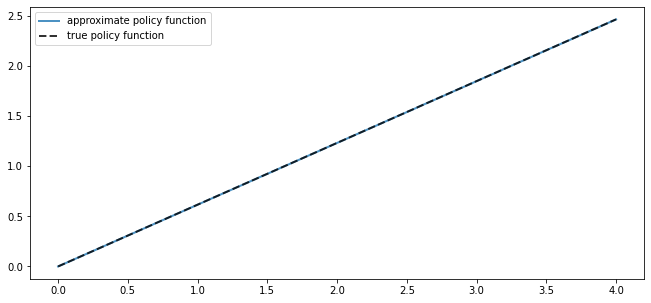

In [10]:
fig, ax = plt.subplots()

ax.plot(og.grid, v_greedy, lw=2,
        alpha=0.8, label='approximate policy function')

ax.plot(og.grid, σ_star(og.grid, og.α, og.β), 'k--',
        lw=2, alpha=0.8, label='true policy function')

ax.legend()
plt.show()

Again, the fit is excellent --- this is as expected since we have not changed
the algorithm.

The maximal absolute deviation between the two policies is

In [11]:
np.max(np.abs(v_greedy - σ_star(og.grid, og.α, og.β)))

0.0010480539639137199

## Exercises

```{exercise}
:label: ogfast_ex1

Time how long it takes to iterate with the Bellman operator
20 times, starting from initial condition $v(y) = u(y)$.

Use the default parameterization.
```

### Exercise 2
```{exercise}
:label: ogfast_ex2

Modify the optimal growth model to use the CRRA utility specification.

$$
u(c) = \frac{c^{1 - \gamma} } {1 - \gamma}
$$

Set `γ = 1.5` as the default value and maintaining other specifications.

(Note that `jitclass` currently does not support inheritance, so you will
have to copy the class and change the relevant parameters and methods.)

Compute an estimate of the optimal policy, plot it and compare visually with
the same plot from the {ref}`analogous exercise <og_ex1>` in the first optimal
growth lecture.

Compare execution time as well.
```


```{exercise-start}
:label: ogfast_ex3
```

In this exercise we return to the original log utility specification.

Once an optimal consumption policy $\sigma$ is given, income follows

$$
y_{t+1} = f(y_t - \sigma(y_t)) \xi_{t+1}
$$

The next figure shows a simulation of 100 elements of this sequence for three
different discount factors (and hence three different policies).

```{figure} /_static/lecture_specific/optgrowth/solution_og_ex2.png
```

In each sequence, the initial condition is $y_0 = 0.1$.

The discount factors are `discount_factors = (0.8, 0.9, 0.98)`.

We have also dialed down the shocks a bit with `s = 0.05`.

Otherwise, the parameters and primitives are the same as the log-linear model discussed earlier in the lecture.

Notice that more patient agents typically have higher wealth.

Replicate the figure modulo randomness.

```{exercise-end}
```

## Solutions

```{solution-start} ogfast_ex1
:class: dropdown
```

Let's set up the initial condition.

In [12]:
v = og.u(og.grid)

Here's the timing:

In [13]:
%%time

for i in range(20):
    v_greedy, v_new = T(v, og)
    v = v_new

CPU times: user 181 ms, sys: 17 µs, total: 181 ms
Wall time: 181 ms


Compared with our {ref}`timing <og_ex2>` for the non-compiled version of
value function iteration, the JIT-compiled code is usually an order of magnitude faster.

```{solution-end}
```


```{solution-start} ogfast_ex2
:class: dropdown
```

Here's our CRRA version of `OptimalGrowthModel`:

In [14]:


opt_growth_data = [
    ('α', float64),          # Production parameter
    ('β', float64),          # Discount factor
    ('μ', float64),          # Shock location parameter
    ('γ', float64),          # Preference parameter
    ('s', float64),          # Shock scale parameter
    ('grid', float64[:]),    # Grid (array)
    ('shocks', float64[:])   # Shock draws (array)
]

@jitclass(opt_growth_data)
class OptimalGrowthModel_CRRA:

    def __init__(self,
                α=0.4, 
                β=0.96, 
                μ=0,
                s=0.1,
                γ=1.5, 
                grid_max=4,
                grid_size=120,
                shock_size=250,
                seed=1234):

        self.α, self.β, self.γ, self.μ, self.s = α, β, γ, μ, s

        # Set up grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)

        # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))
       

    def f(self, k):
        "The production function."
        return k**self.α

    def u(self, c):
        "The utility function."
        return c**(1 - self.γ) / (1 - self.γ)

    def f_prime(self, k):
        "Derivative of f."
        return self.α * (k**(self.α - 1))

    def u_prime(self, c):
        "Derivative of u."
        return c**(-self.γ)

    def u_prime_inv(c):
        return c**(-1 / self.γ)



Let's create an instance:

In [15]:
og_crra = OptimalGrowthModel_CRRA()

Now we call `solve_model`, using the `%%time` magic to check how long it
takes.

In [16]:
%%time
v_greedy, v_solution = solve_model(og_crra)

Error at iteration 25 is 1.6201897527234905.


Error at iteration 50 is 0.459106047057503.


Error at iteration 75 is 0.165423522162655.


Error at iteration 100 is 0.05961808343499797.


Error at iteration 125 is 0.021486161531569792.


Error at iteration 150 is 0.007743542074422294.


Error at iteration 175 is 0.002790747140650751.


Error at iteration 200 is 0.001005776107120937.


Error at iteration 225 is 0.0003624784085332067.


Error at iteration 250 is 0.00013063602793295104.

Converged in 257 iterations.
CPU times: user 3.76 s, sys: 7.76 ms, total: 3.77 s
Wall time: 3.76 s


Here is a plot of the resulting policy:

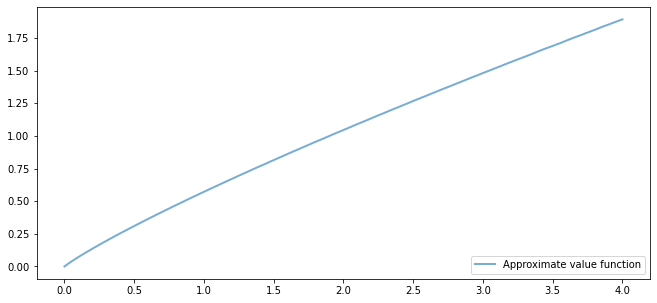

In [17]:
fig, ax = plt.subplots()

ax.plot(og.grid, v_greedy, lw=2,
        alpha=0.6, label='Approximate value function')

ax.legend(loc='lower right')
plt.show()

This matches the solution that we obtained in our non-jitted code,
{ref}`in the exercises <og_ex1>`.

Execution time is an order of magnitude faster.

```{solution-end}
```


```{solution-start} ogfast_ex3
:class: dropdown
```

Here's one solution:

In [18]:
def simulate_og(σ_func, og, y0=0.1, ts_length=100):
    '''
    Compute a time series given consumption policy σ.
    '''
    y = np.empty(ts_length)
    ξ = np.random.randn(ts_length-1)
    y[0] = y0
    for t in range(ts_length-1):
        y[t+1] = (y[t] - σ_func(y[t]))**og.α * np.exp(og.μ + og.s * ξ[t])
    return y

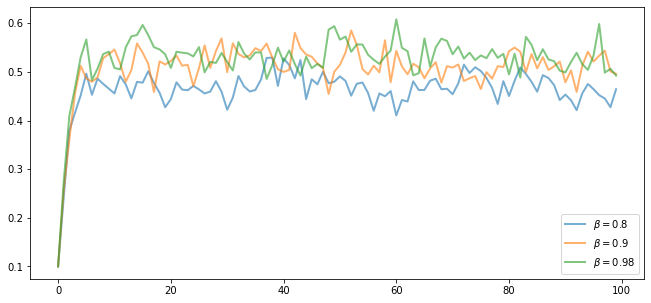

In [19]:
fig, ax = plt.subplots()

for β in (0.8, 0.9, 0.98):

    og = OptimalGrowthModel(β=β, s=0.05)

    v_greedy, v_solution = solve_model(og, verbose=False)

    # Define an optimal policy function
    σ_func = lambda x: interp(og.grid, v_greedy, x)
    y = simulate_og(σ_func, og)
    ax.plot(y, lw=2, alpha=0.6, label=rf'$\beta = {β}$')

ax.legend(loc='lower right')
plt.show()

```{solution-end}
```